## DM-28157 Direct fc1, fc2 solution generation for replacement values


 * Generate the fc1, fc2 model Gaussian solution directly in frequency space to account for correct convergence
 * It looks that the best to check the radii for the PSFs (depends on the width sigmas) and for the solutions as well (depends on width sigmas' difference)
 * Here outside the cutting frequency, we replace the solution with the directly generated "theoretical" ones. This provides a smoother transition at the cutting frequency and goes smooth to the limiting value, if it's reached at all until freq. 1/2.

## Conclusions

 * The wider the PSF, the worse the 31x31 PSF image with respect to the window function oscillating tail. 5*sigma tails seem to be a satisfactory limit (i.e. 10 sigma for both sides, sigma<=3.1)
 * The closer the two PSF widths are, the slower the convergence of the matching kernel solutions.
 * Using this theoretical model replacement gives satisfactory results for many input sigma combinations.

### Notation of calculated quantities

$c_1$, $c_2$: Matching kernels for the input images A, B.
$fc_1$, $fc_2$: The matching kernels in Fourier space.

$P_d$ : the PSF of the difference image, the result of the PSF matching for both images.

$w\sigma_1$, $w\sigma_2$: The PSF (width) sigma of Gaussian image PSFs in _image space_.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
%run -b -i "TwoD_gaussian_in_freq_space.py"
%run -b -i "array_freq_cut.py"

In [2]:
from lsst.ip.diffim.zogy import ZogyTask, ZogyConfig
config = ZogyConfig()
config.scaleByCalibration = False
task = ZogyTask(config=config)

Check out how the directly generated solutions look like

In [3]:
# Noise variance in the images
varMean1 = 100
varMean2 = 100
# Photometric scaling
F1 = 1.
F2 = 1. 

In [4]:
# Here you can play with different input sigmas, in image space, in pixels
# This notebook should not assume which one is the larger
wSig1 = 2.2
wSig2 = 2.

In [5]:
# The generated theoretical solutions. We use these values to replace the DFT results above the cutting frequency.
g_fc1, g_fc2 = calculateDirectModelFc1Fc2(1024, 1024, wSig1, wSig2, varMean1, varMean2)

<IPython.core.display.Javascript object>


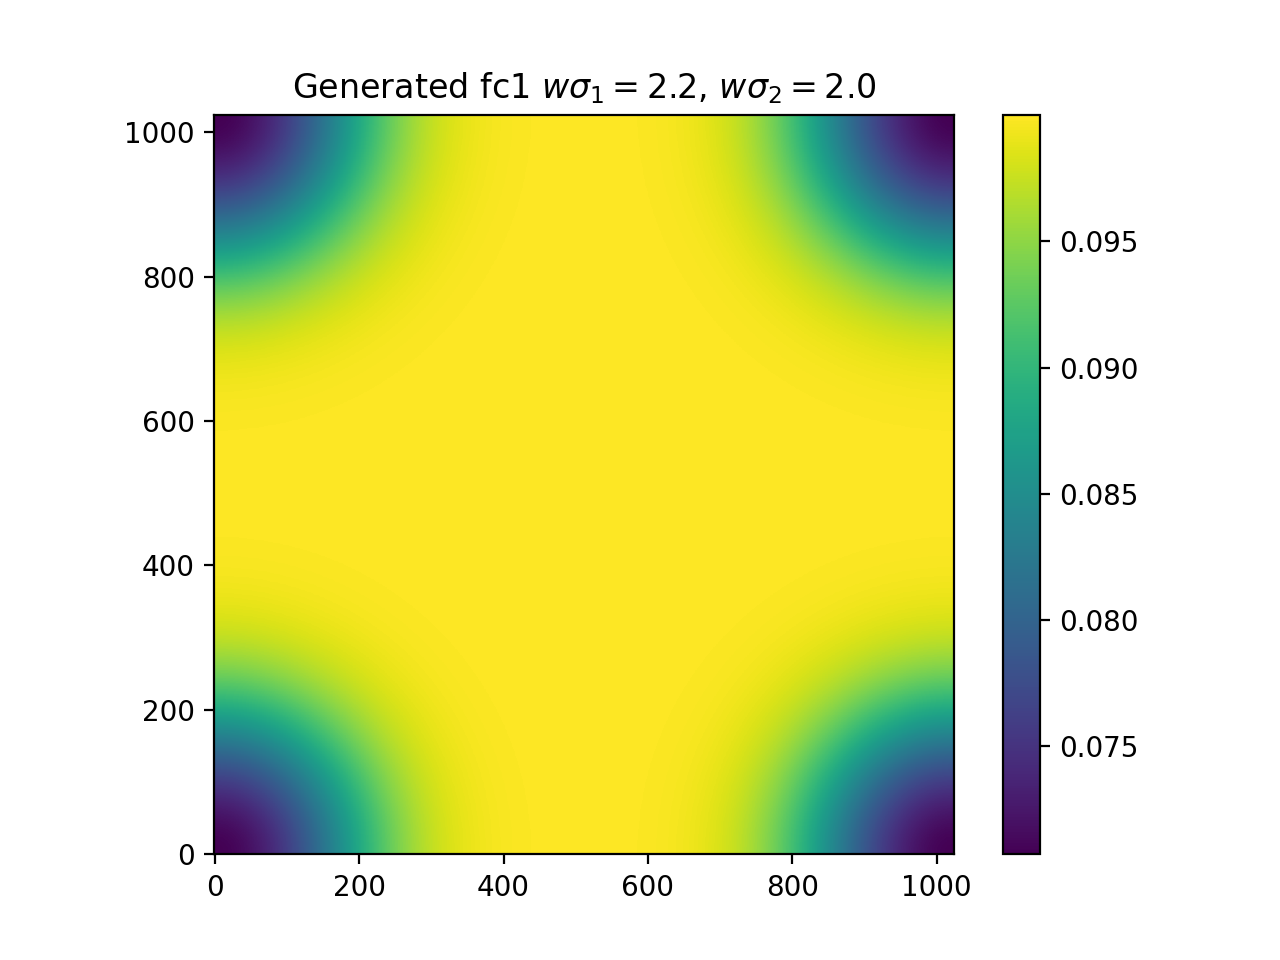

In [6]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(g_fc1, origin='lower', interpolation='none')
ax1.set_title("Generated fc1 $w\sigma_1=${:.1f}, $w\sigma_2=${:.1f}".format(wSig1, wSig2))
fig.colorbar(cs)

<IPython.core.display.Javascript object>


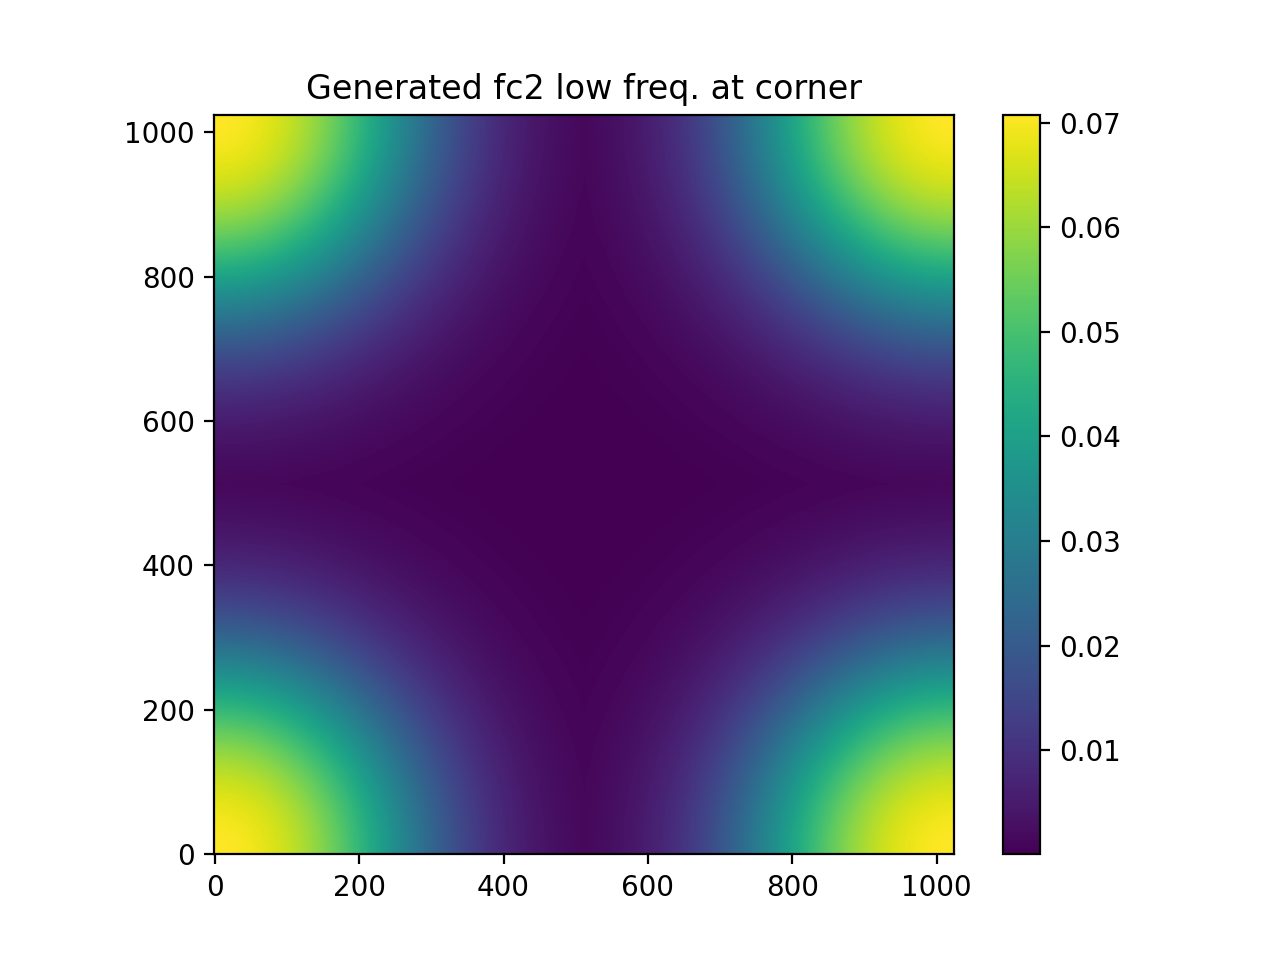

In [7]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(g_fc2, origin='lower', interpolation='none')
ax1.set_title("Generated fc2 low freq. at corner")
fig.colorbar(cs)

In [8]:
g_c1 = np.real(np.fft.ifft2(g_fc1))
g_c2 = np.real(np.fft.ifft2(g_fc2))

The matching kernel for the wider input back in image space

<IPython.core.display.Javascript object>


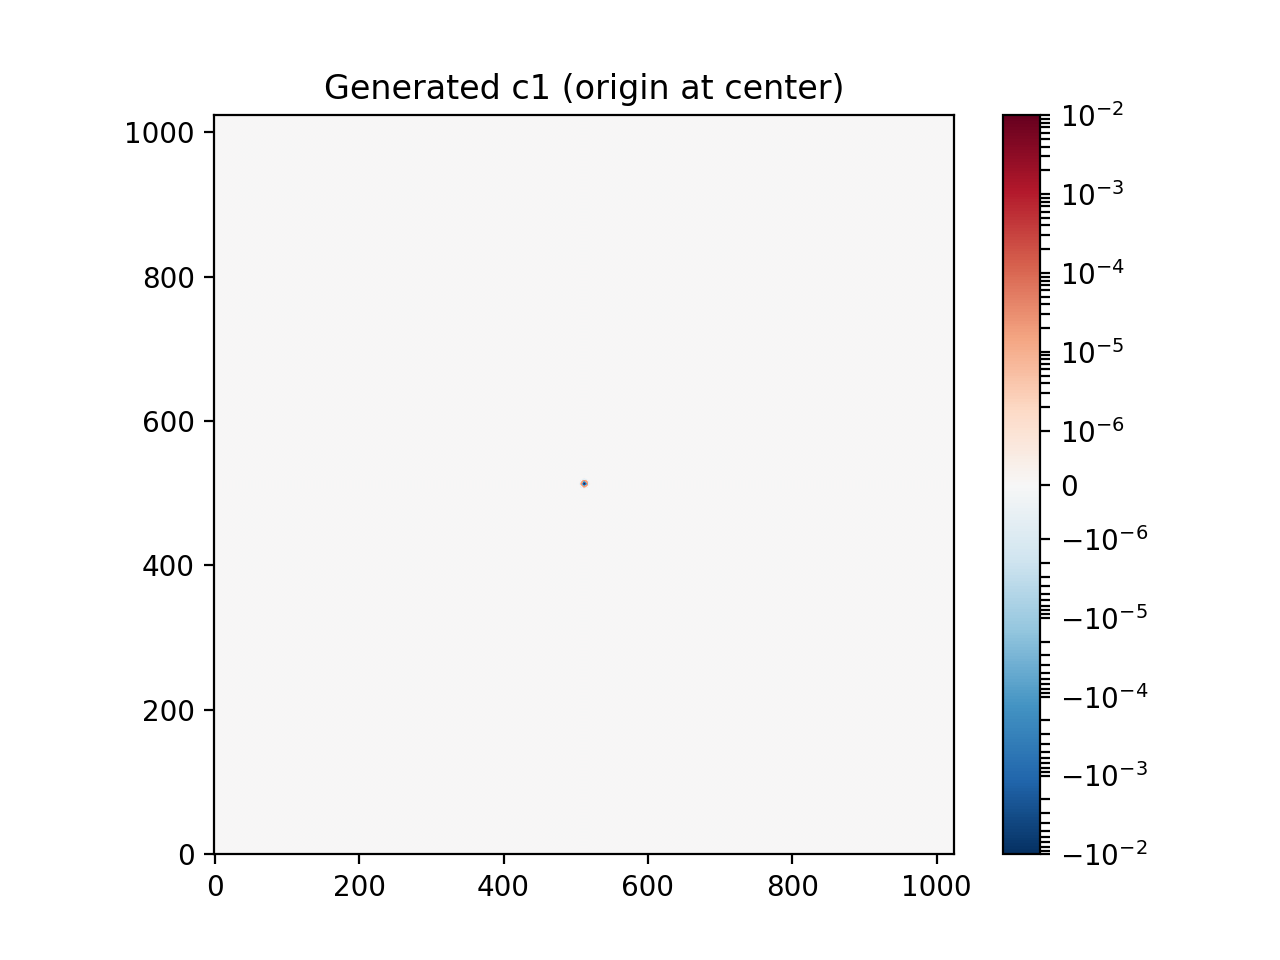

<ipython-input-9-2871a8c395d8>:5: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.01,vmax=0.01))


Text(0.5, 1.0, 'Generated c1 (origin at center)')

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(g_c1, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.01,vmax=0.01))
fig.colorbar(cs)
ax.set_title("Generated c1 (origin at center)")

<IPython.core.display.Javascript object>


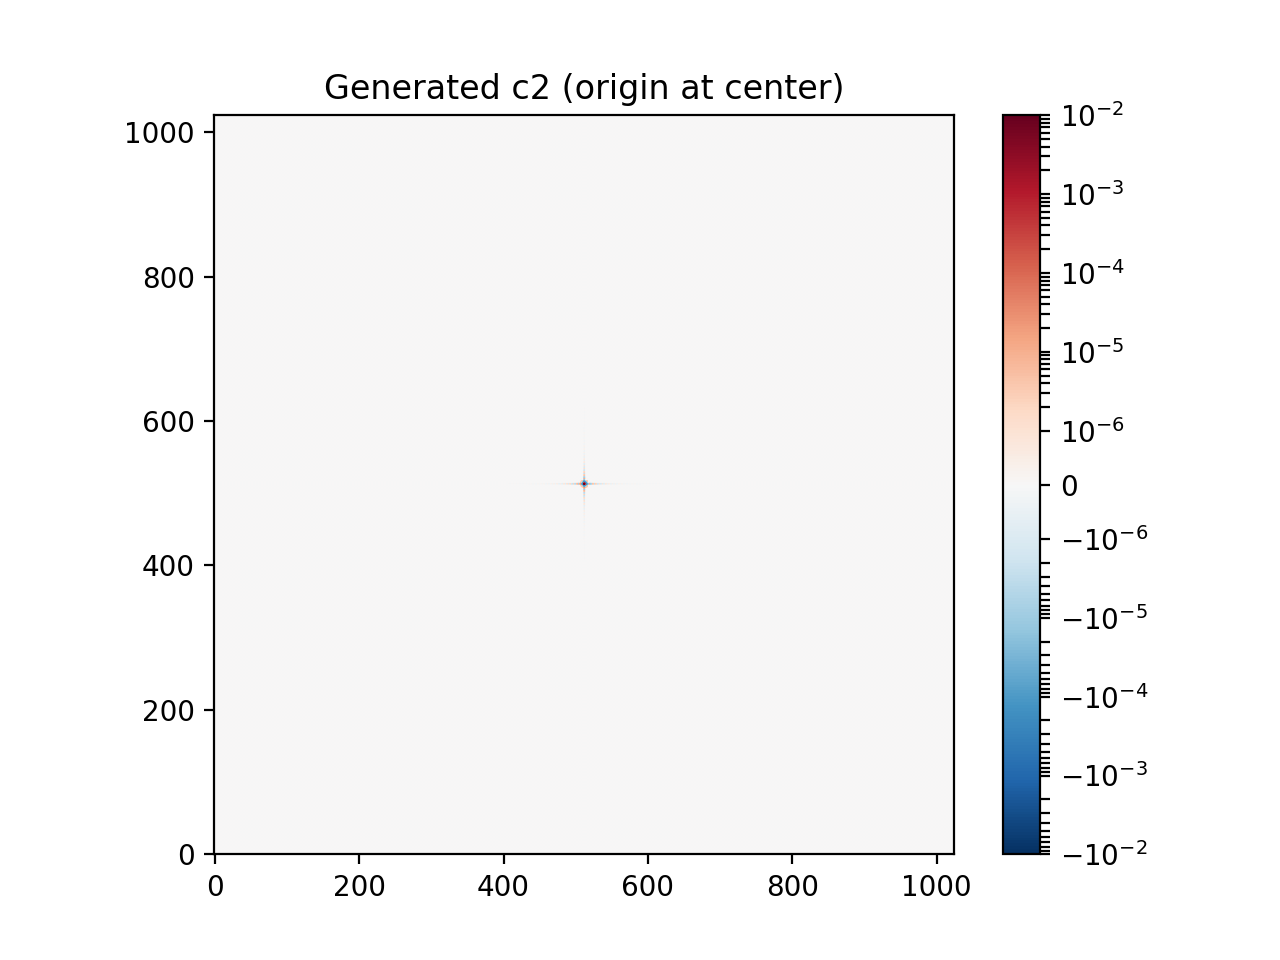

<ipython-input-10-d30a81d40855>:5: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.01,vmax=0.01))


Text(0.5, 1.0, 'Generated c2 (origin at center)')

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(g_c2, (1024, 1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.01,vmax=0.01))
fig.colorbar(cs)
ax.set_title("Generated c2 (origin at center)")

### Now calculate where to cut the DFT solutions.

In [11]:
# We can cut at the frequencies where the solutions reach their constant limit values
fr1, fr2 = calculateCutFrequencies(wSig1, wSig2, varMean1, varMean2, limit=0.999999)
print("Theoretical solution in Fourier space converged:", fr1, fr2)
print("in pixels:", fr1 * 1024, fr2 * 1024)
# But we should cut at a lower frequency if the input PSF tail is reached at a lower frequency 
frp1 = calculateGaussianCutFrequency(wSig1, limit=0.999999)
frp2 = calculateGaussianCutFrequency(wSig2, limit=0.999999)
print ("PSF tails reached in Fourier space:", frp1, frp2)
print ("in pixels:", frp1 * 1024, frp2 * 1024)

Theoretical solution in Fourier space converged: 0.608 0.8
in pixels: 622.592 819.2
PSF tails reached in Fourier space: 0.352 0.392
in pixels: 360.448 401.408


## 31x31 PSFs padded and FFTd
Pad a usual 31x31 pix. PSF then FFT them

In [12]:
A = calculate2dGaussianArray(31, 31, wSig1)
A /= np.sum(A)
pA = task.padCenterOriginArray(A,(1024,1024))
psf1 = np.fft.fft2(pA)
B = calculate2dGaussianArray(31, 31, wSig2)
B /= np.sum(B)
pB = task.padCenterOriginArray(B,(1024,1024))
psf2 = np.fft.fft2(pB)

<IPython.core.display.Javascript object>


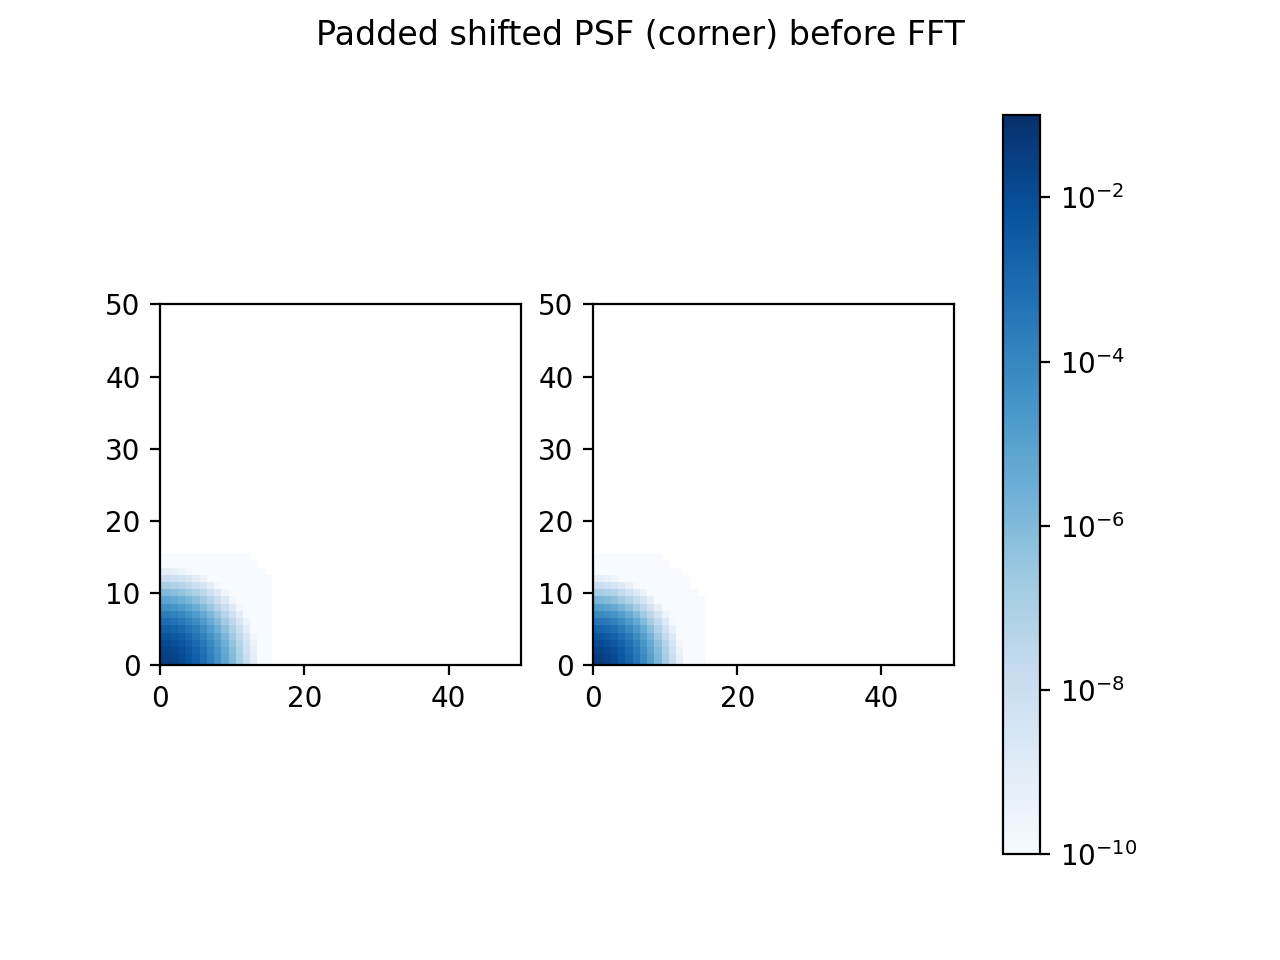

Text(0.5, 0.98, 'Padded shifted PSF (corner) before FFT')

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
cs = ax1.imshow(pA, origin='lower', interpolation='none',  cmap='Blues',
               norm=matplotlib.colors.LogNorm(vmin=1e-10,vmax=0.1))
ax2 = fig.add_subplot(1, 2, 2)
cs = ax2.imshow(pB, origin='lower', interpolation='none',  cmap='Blues',
               norm=matplotlib.colors.LogNorm(vmin=1e-10,vmax=0.1))
fig.colorbar(cs, ax=[ax1, ax2])
ax1.set_xlim(0, 50)
ax1.set_ylim(0, 50)
ax2.set_xlim(0, 50)
ax2.set_ylim(0, 50)
fig.suptitle("Padded shifted PSF (corner) before FFT")

<IPython.core.display.Javascript object>


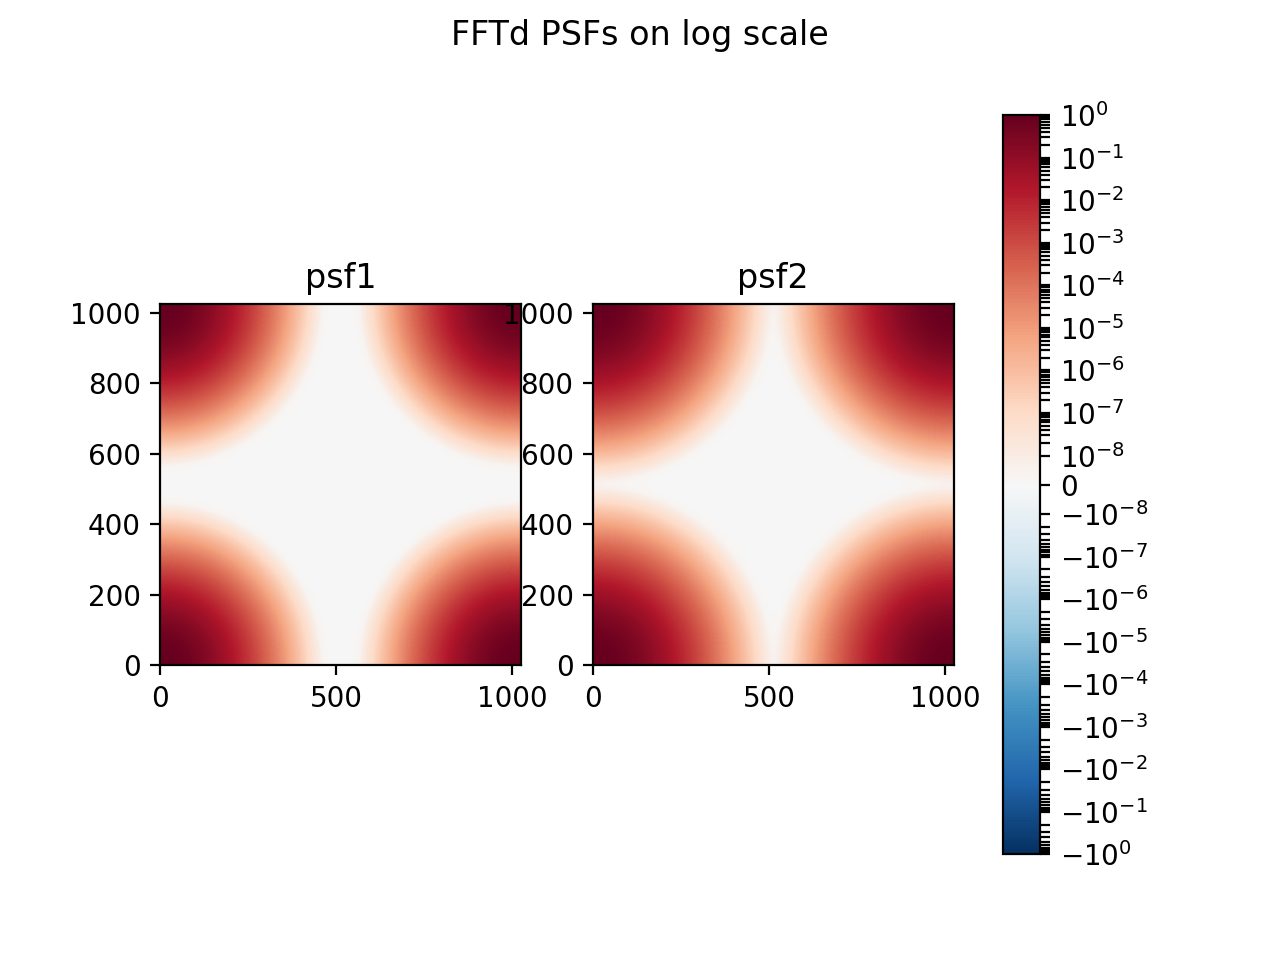

<ipython-input-14-e1739fef1857>:4: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm=matplotlib.colors.SymLogNorm(linthresh=1e-8,vmin=-1,vmax=1))
<ipython-input-14-e1739fef1857>:8: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm=matplotlib.colors.SymLogNorm(linthresh=1e-8,vmin=-1,vmax=1))


Text(0.5, 0.98, 'FFTd PSFs on log scale')

In [14]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
cs = ax1.imshow(psf1.real, origin='lower', interpolation='none',  cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8,vmin=-1,vmax=1))
ax1.set_title("psf1")
ax2 = fig.add_subplot(1, 2, 2)
cs = ax2.imshow(psf2.real, origin='lower', interpolation='none',  cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8,vmin=-1,vmax=1))
ax2.set_title("psf2")
fig.colorbar(cs, ax=[ax1, ax2])
fig.suptitle("FFTd PSFs on log scale")

There are some small negative values around in the frequency space PSFs.

In [15]:
var1F2Sq = varMean1*F2*F2
var2F1Sq = varMean2*F1*F1
FdDenom = np.sqrt(var1F2Sq + var2F1Sq)  # one number
# We need reals for comparison, also real operations are usually faster
# Psf absolute squared
psfAbsSq1 = np.real(np.conj(psf1)*psf1)
psfAbsSq2 = np.real(np.conj(psf2)*psf2)
sDenom = var1F2Sq*psfAbsSq2 + var2F1Sq*psfAbsSq1  # array, eq. (12)
# sDenom close to zero check here in the code, here we ignore, we won't hit division by zero
denom = np.sqrt(sDenom)  # array, eq. (13)

sDenom: The squared denominator in the difference image calculation

In [16]:
fPd = FdDenom*psf1*psf2/denom  # Psf of D eq. (14)
fc1 = psf2/denom
fc2 = psf1/denom

In [17]:
print(FdDenom)

14.142135623730951


Check all are real.

In [34]:
print(np.all(fPd.imag == 0), np.all(fc1.imag == 0), np.all(fc2.imag == 0))
assert np.all(fc2.imag == 0), "Symmetry broken or hit nan by zero division! Protect against zero division."

True True True


<IPython.core.display.Javascript object>


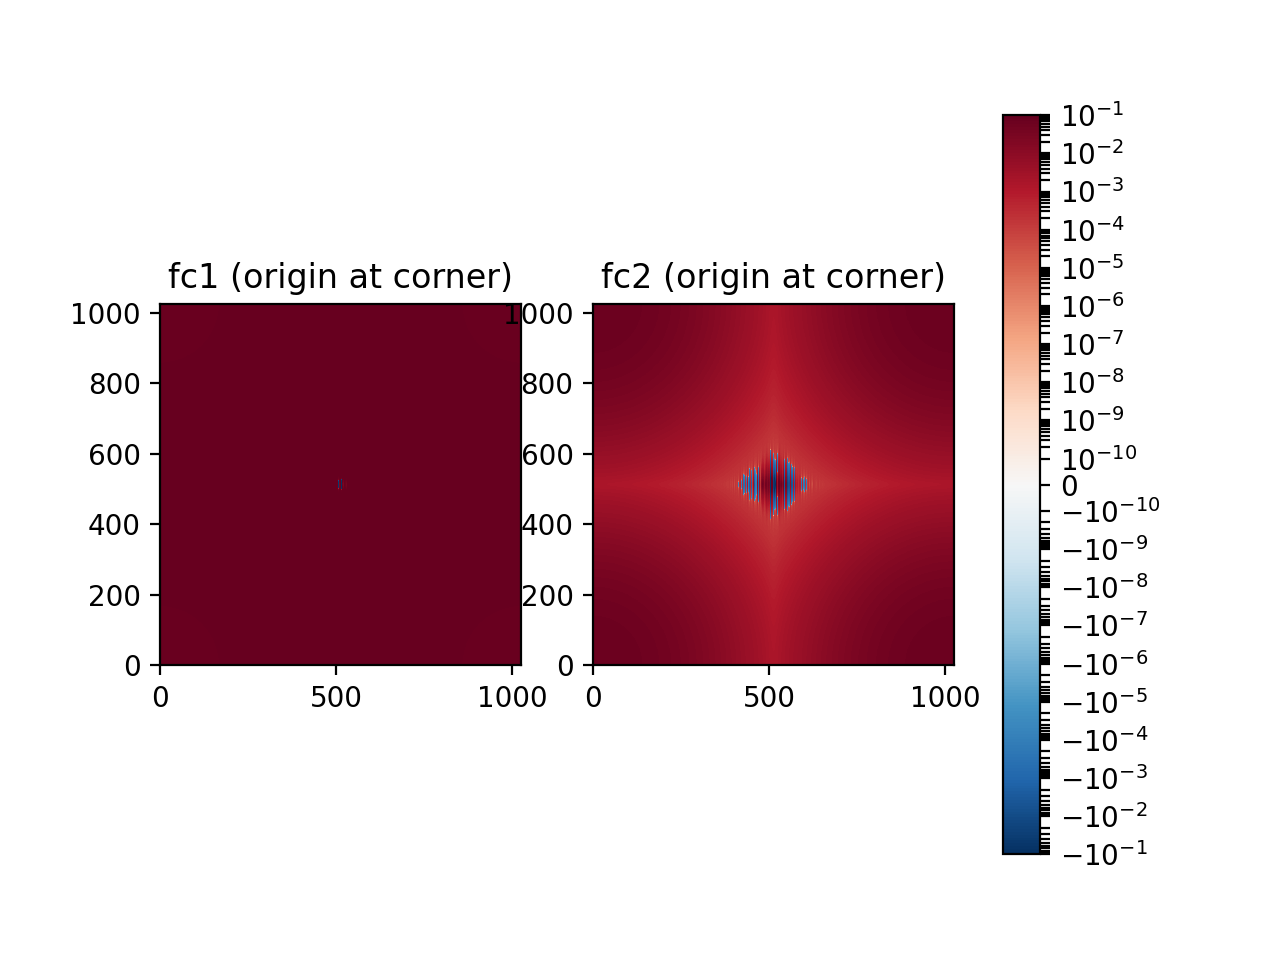

<ipython-input-19-6fcd23b871f3>:4: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm=matplotlib.colors.SymLogNorm(linthresh=1e-10,vmin=-0.1,vmax=0.1))
<ipython-input-19-6fcd23b871f3>:8: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm=matplotlib.colors.SymLogNorm(linthresh=1e-10,vmin=-0.1,vmax=0.1))


fc1 min -0.09789503182800316
fc1 max 0.09999999999999316
fc2 min -0.09999968092148062
fc2 max 0.09999999999999316


In [19]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
cs = ax1.imshow(fc1.real, origin='lower', interpolation='none', cmap='RdBu_r',
                norm=matplotlib.colors.SymLogNorm(linthresh=1e-10,vmin=-0.1,vmax=0.1))
ax1.set_title("fc1 (origin at corner)")
ax2 = fig.add_subplot(1, 2, 2)
cs = ax2.imshow(fc2.real, origin='lower', interpolation='none', cmap='RdBu_r',
                norm=matplotlib.colors.SymLogNorm(linthresh=1e-10,vmin=-0.1,vmax=0.1))
ax2.set_title("fc2 (origin at corner)")
fig.colorbar(cs, ax=[ax1, ax2])
print(f"fc1 min {np.min(fc1.real)}")
print(f"fc1 max {np.max(fc1.real)}")
print(f"fc2 min {np.min(fc2.real)}")
print(f"fc2 max {np.max(fc1.real)}")

The matching kernel for the wider input PSF

<IPython.core.display.Javascript object>


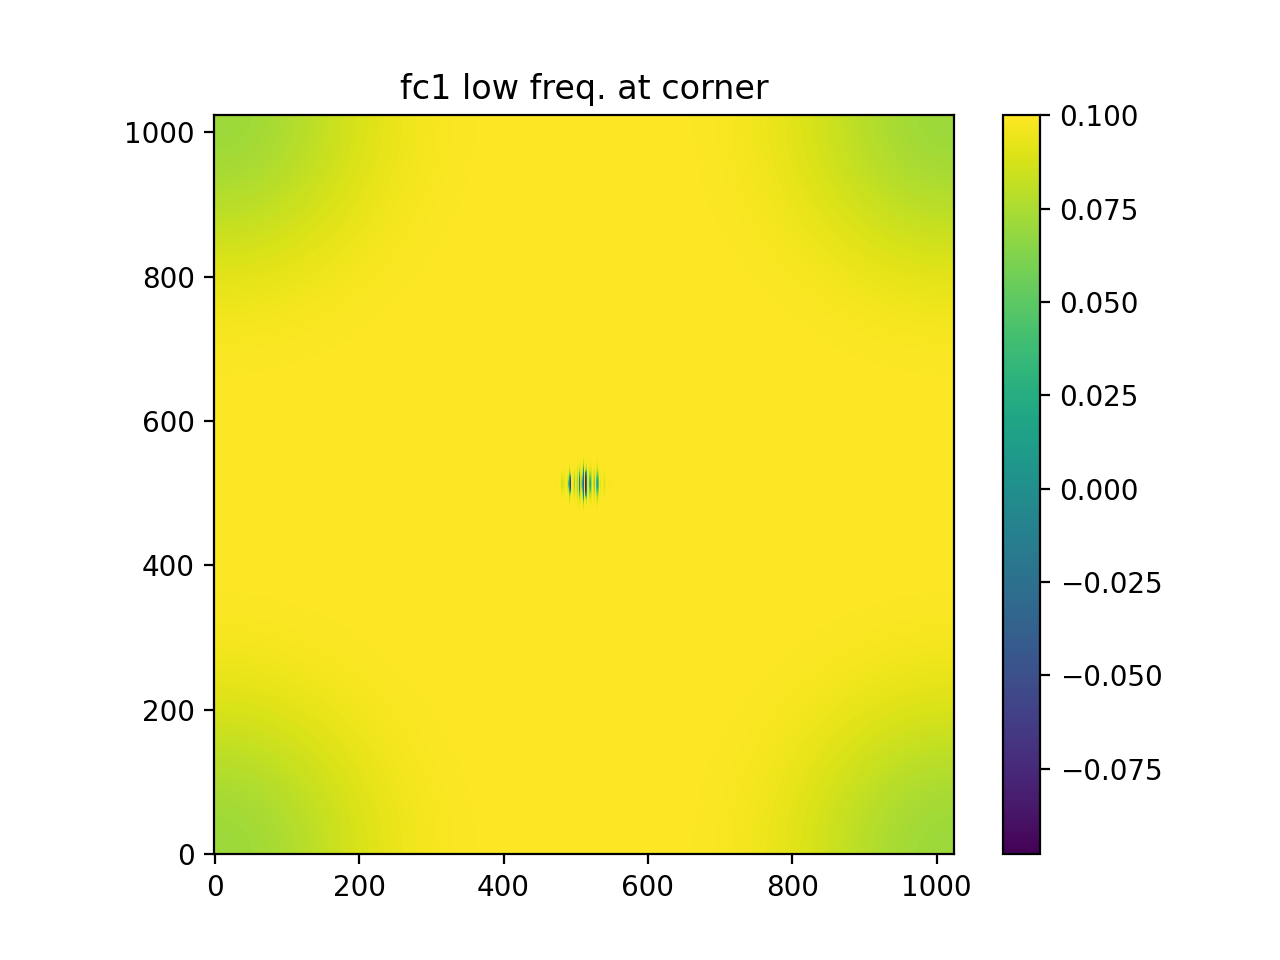

In [20]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(fc1.real, origin='lower', interpolation='none')
ax1.set_title("fc1 low freq. at corner")
fig.colorbar(cs)

In [21]:
rN = np.minimum(fr1, frp2) * 1024
freqFlt1 = makeRectQuartersMaskArray((1024, 1024), rN , rN)

<IPython.core.display.Javascript object>


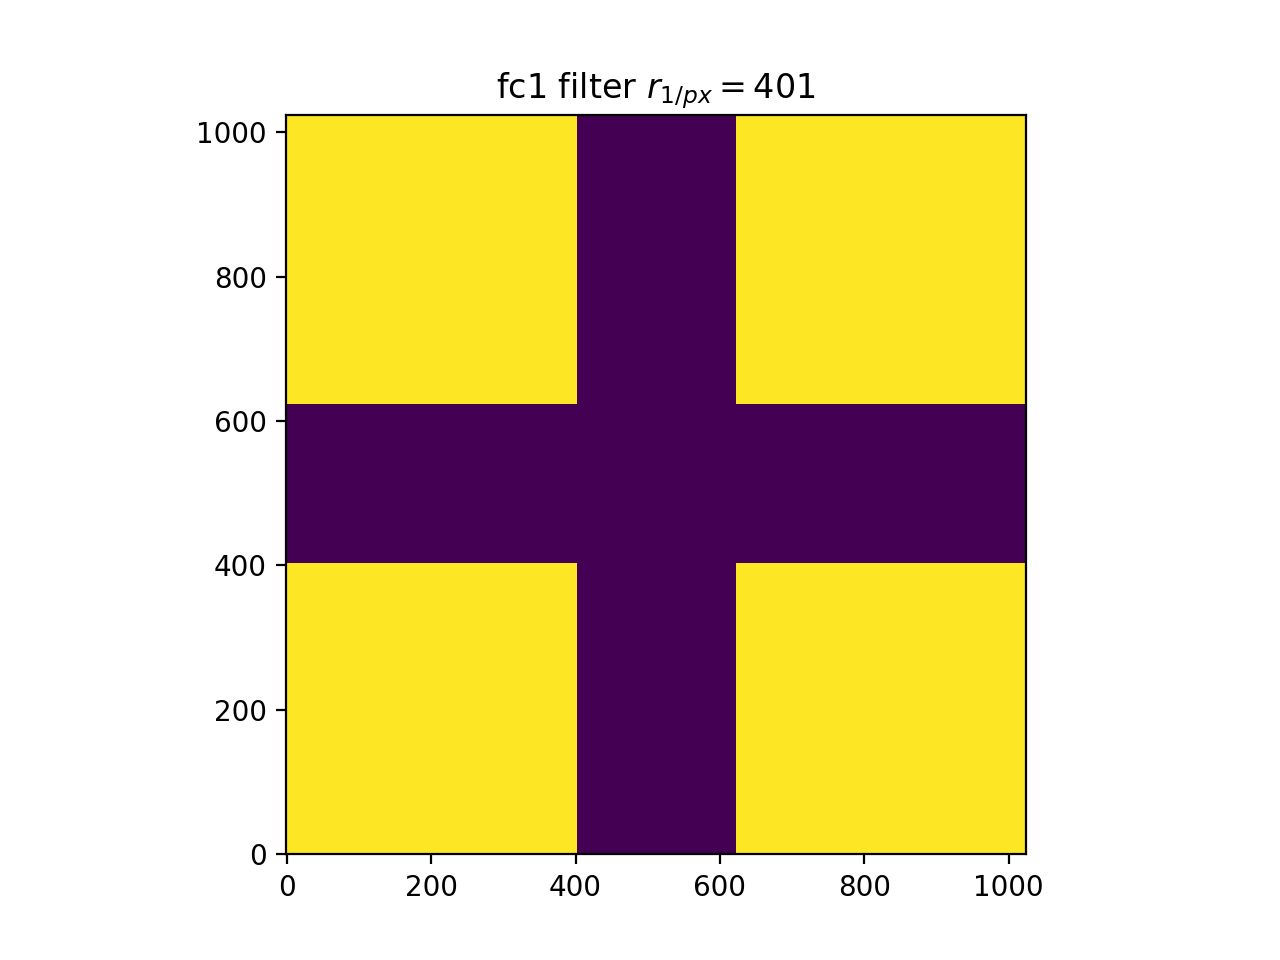

Text(0.5, 1.0, 'fc1 filter $r_{1/px}=$401')

In [22]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(np.asarray(freqFlt1, dtype=int), origin='lower', interpolation='none')
ax1.set_title("fc1 filter $r_{{1/px}}=${:.0f}".format(rN))

In [23]:
freqFlt1 = np.logical_not(freqFlt1)
fc1[freqFlt1] = g_fc1[freqFlt1]

<IPython.core.display.Javascript object>


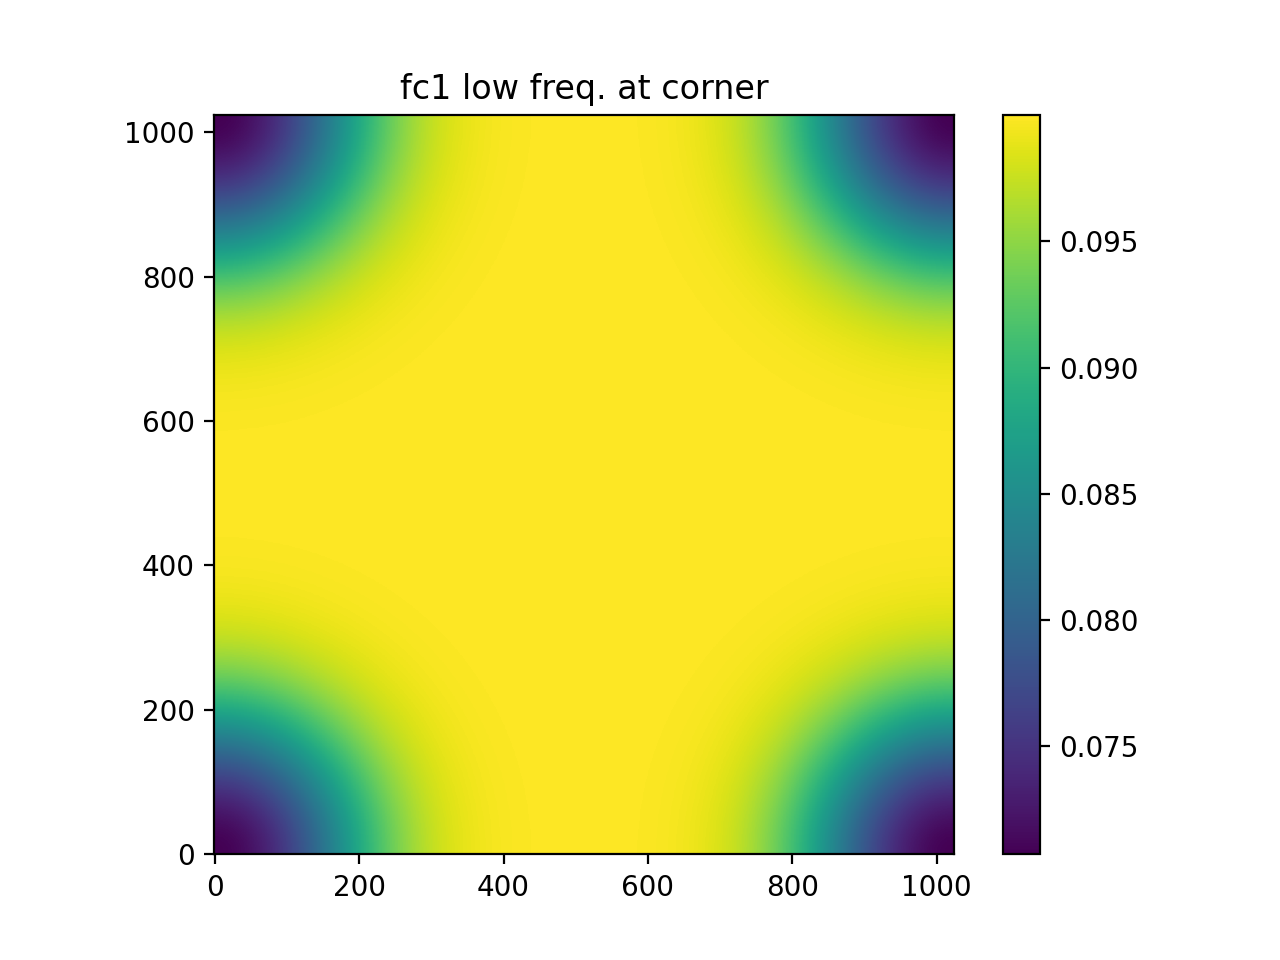

In [24]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(fc1.real, origin='lower', interpolation='none')
ax1.set_title("fc1 low freq. at corner")
fig.colorbar(cs)

The matching kernel for the narrower input PSF

<IPython.core.display.Javascript object>


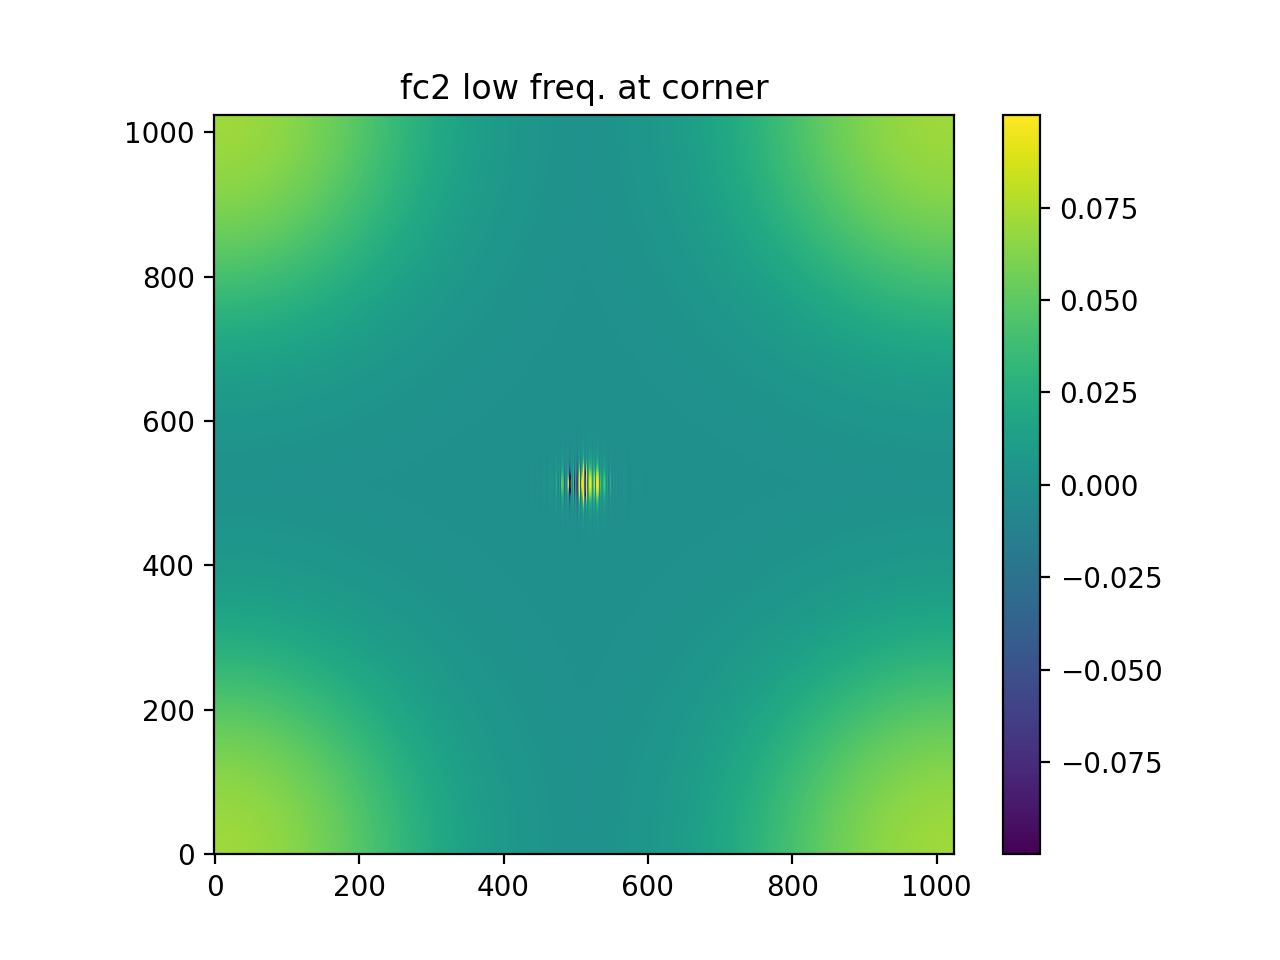

In [25]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(fc2.real, origin='lower', interpolation='none')
ax1.set_title("fc2 low freq. at corner")
fig.colorbar(cs)

In [26]:
rN = np.minimum(fr2, frp1) * 1024
freqFlt2 = makeRectQuartersMaskArray((1024, 1024), rN , rN)

<IPython.core.display.Javascript object>


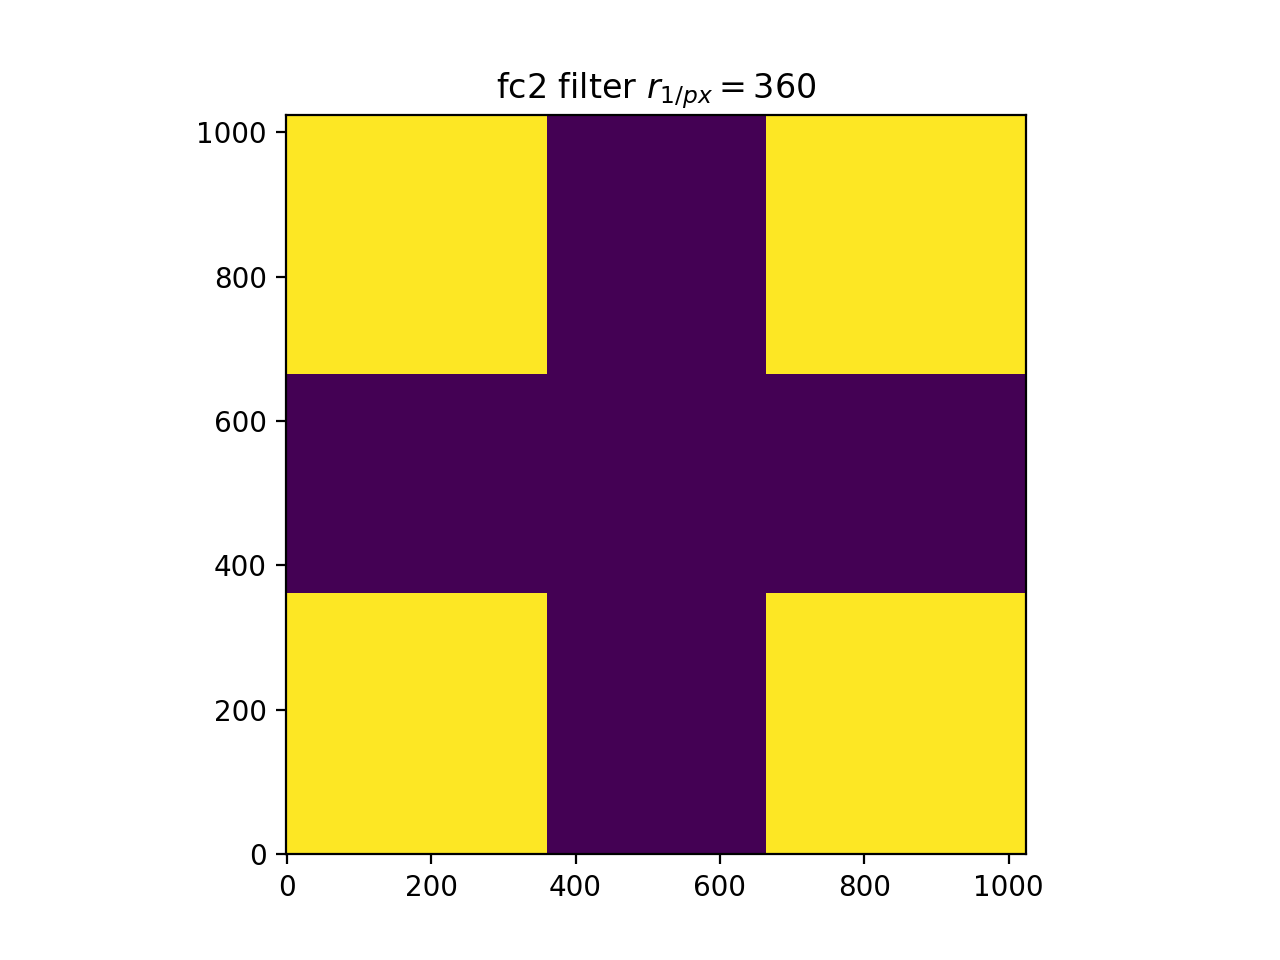

Text(0.5, 1.0, 'fc2 filter $r_{1/px}=$360')

In [27]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(np.asarray(freqFlt2, dtype=int), origin='lower', interpolation='none')
ax1.set_title("fc2 filter $r_{{1/px}}=${:.0f}".format(rN))

In [28]:
freqFlt2 = np.logical_not(freqFlt2)
fc2[freqFlt2] = g_fc2[freqFlt2]

<IPython.core.display.Javascript object>


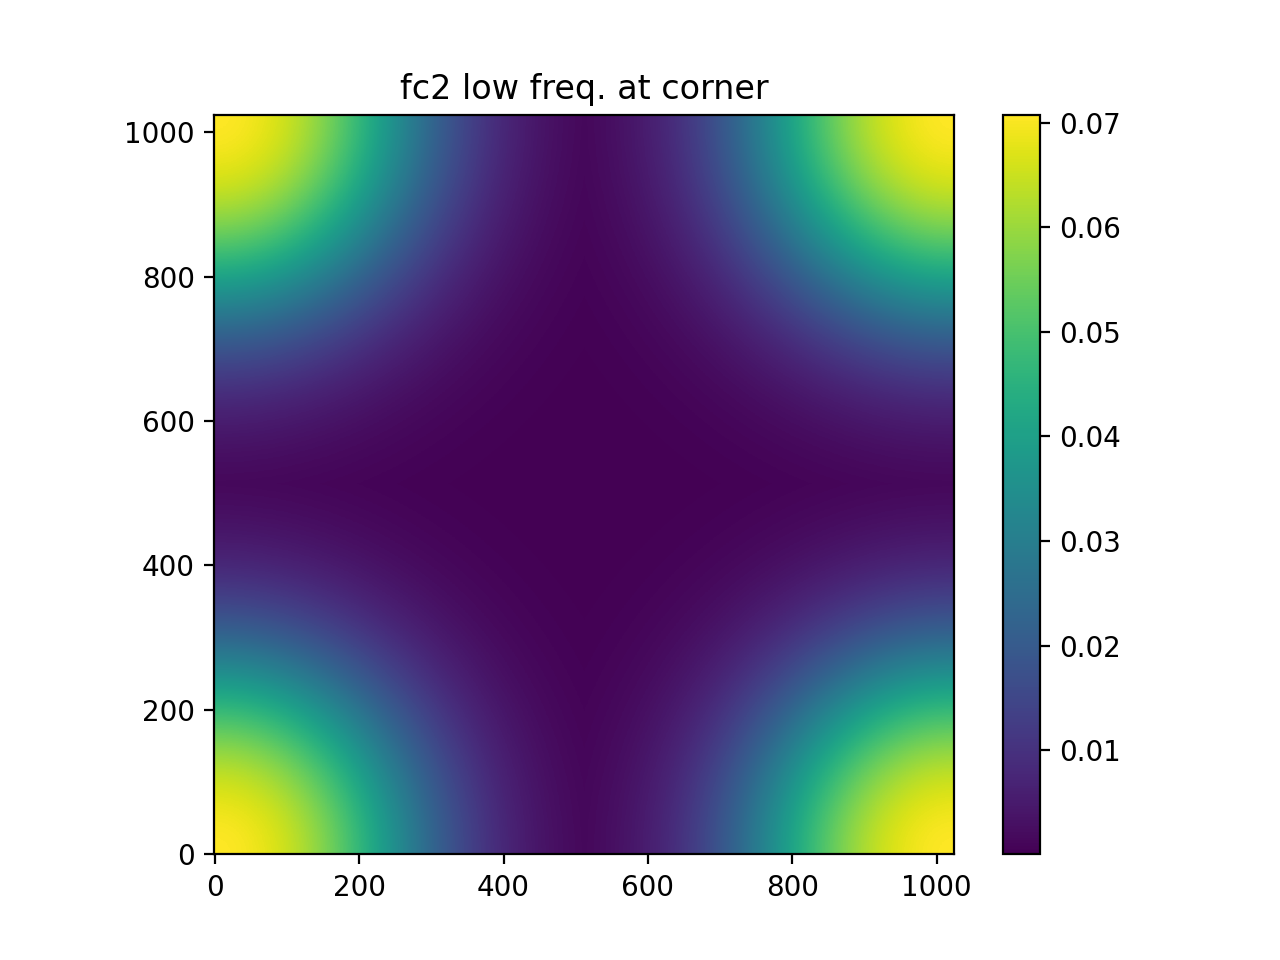

In [29]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(fc2.real, origin='lower', interpolation='none')
ax1.set_title("fc2 low freq. at corner")
fig.colorbar(cs)

In [30]:
Pd = np.real(np.fft.ifft2(fPd))
c1 = np.real(np.fft.ifft2(fc1))
c2 = np.real(np.fft.ifft2(fc2))

The matching kernel for the wider input back in image space

<IPython.core.display.Javascript object>


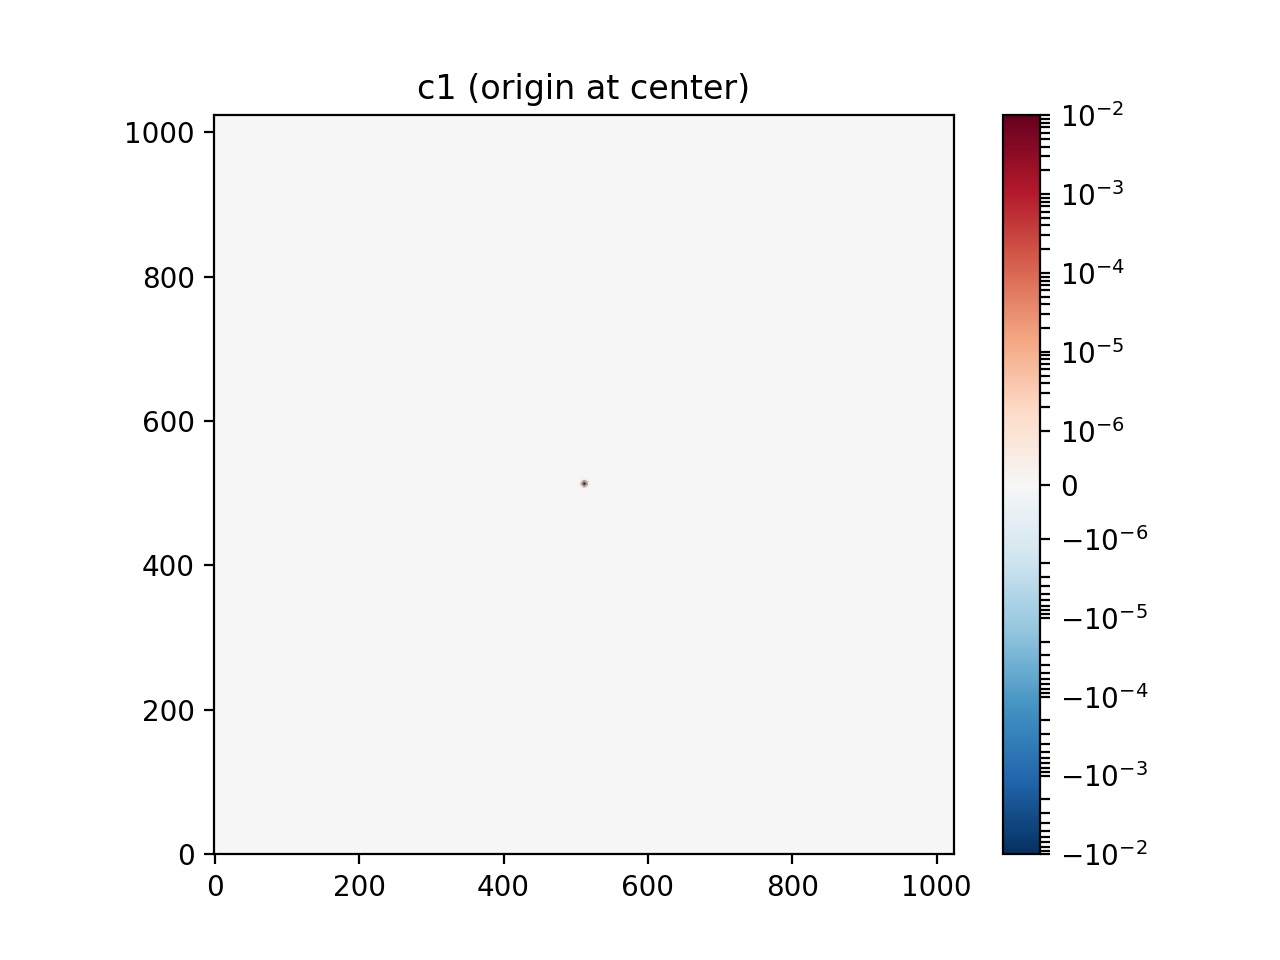

<ipython-input-31-3c4540477c10>:5: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.01,vmax=0.01))


Text(0.5, 1.0, 'c1 (origin at center)')

In [31]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(c1, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.01,vmax=0.01))
fig.colorbar(cs)
ax.set_title("c1 (origin at center)")

And for the narrower one

<IPython.core.display.Javascript object>


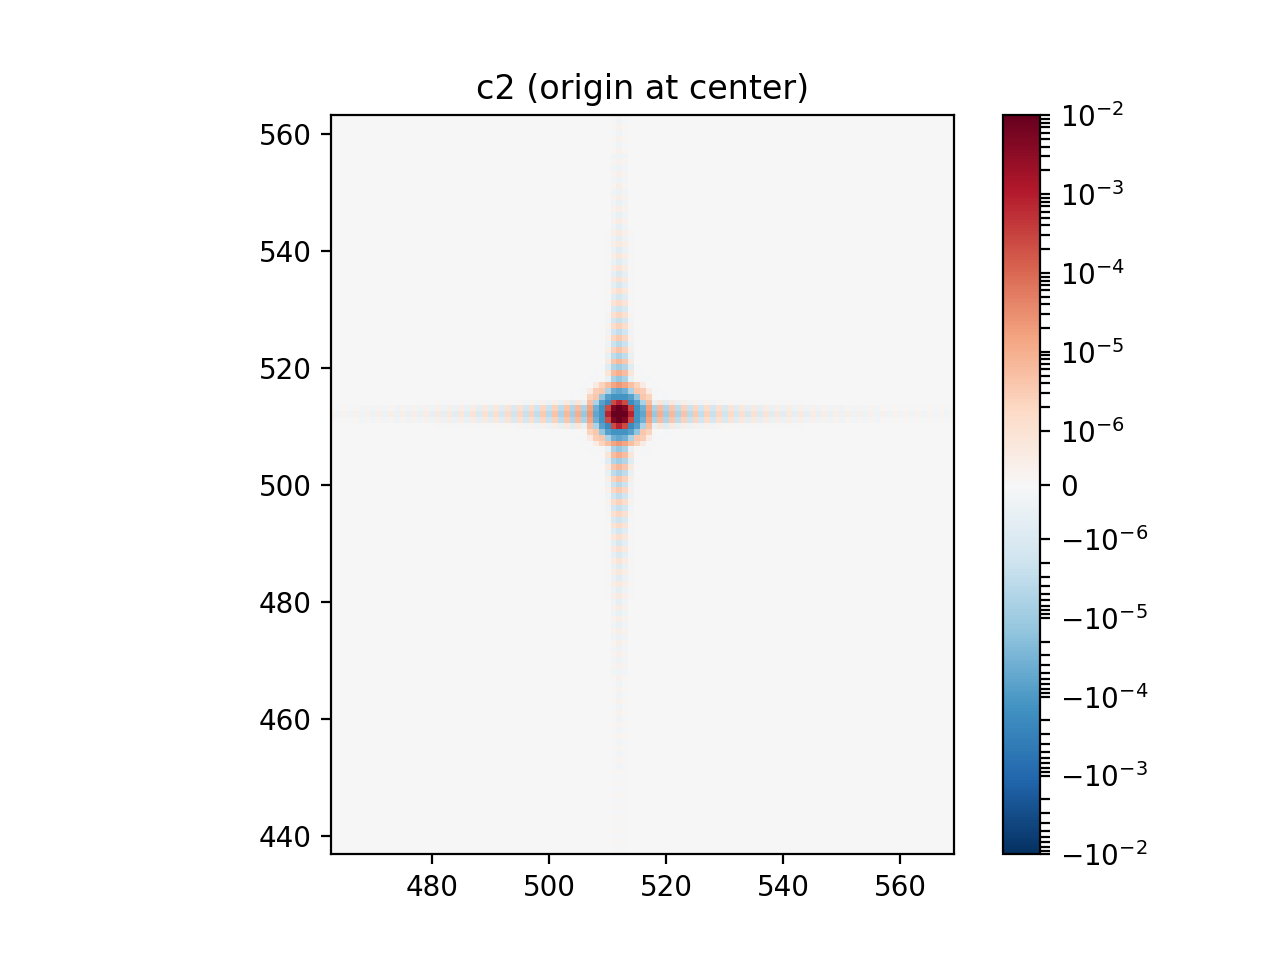

<ipython-input-32-afd188e863ac>:5: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.01,vmax=0.01))


Text(0.5, 1.0, 'c2 (origin at center)')

In [32]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(c2, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.01,vmax=0.01))
fig.colorbar(cs)
ax.set_title("c2 (origin at center)")

PSF for the difference image

<IPython.core.display.Javascript object>


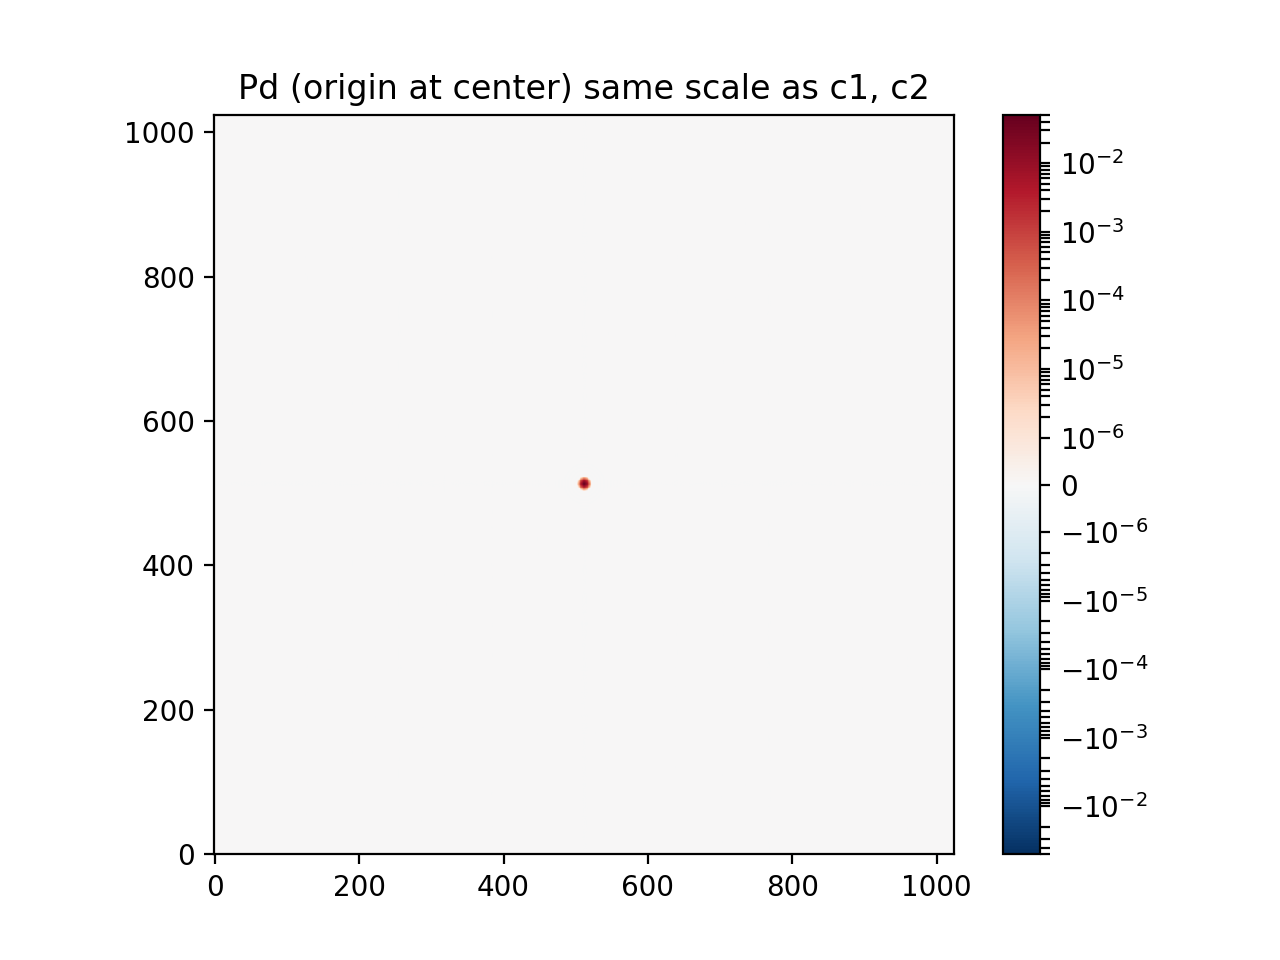

<ipython-input-33-6e075ed90360>:5: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.05,vmax=0.05))


Text(0.5, 1.0, 'Pd (origin at center) same scale as c1, c2')

In [33]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(Pd, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.05,vmax=0.05))
fig.colorbar(cs)
ax.set_title("Pd (origin at center) same scale as c1, c2")

--------